In [1]:
from codebase.topic_utilities import dtm_csv_to_pd_df

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

# 0. Define Path Information

In [2]:
# params
fileTag = "Whole-March-Tweets"
num_topics = 25

# fixed params
corpora_path = "./corpora/"
model_path = "./models/"
model_suffix = "-{}topics".format(num_topics)

## 1. Load MetaData & Document-Topic Matrix

In [3]:
%%time
metadata_filename = "{}{}-Meta.csv".format(corpora_path, fileTag)
# Read back data from csv files
metadata = pd.read_csv(metadata_filename)
doc_topic_matrix_filename = "{}{}{}-dtm.csv".format(model_path, fileTag, model_suffix)
dtm = dtm_csv_to_pd_df(doc_topic_matrix_filename)

CPU times: user 42.2 s, sys: 8.05 s, total: 50.3 s
Wall time: 53.1 s


## 2.1 Prevalence of the Top Topic per Day
### Format the dataframe

In [4]:
%%time
# select top contributed topic of each tweet
df_max = dtm.idxmax(axis=1).to_frame().reset_index()
df_max.columns = ["position_index", "max_topic"]

# merge with metadata for fecthing date
df_max = df_max.merge(metadata, on="position_index", how="left")
df_max['preDate'] = pd.to_datetime(df_max['created_time'])
# format the Date column for grouping conveniently
df_max["Date"] = df_max["preDate"].dt.strftime("%Y-%m-%d")

# groupby [date, top_topics] aggregate by count(id_str)
max_counts = df_max[['id_str', 'Date', 'max_topic']].groupby(['Date', 'max_topic']).agg({'id_str' : 'count'}).reset_index()
max_counts.columns = ['Date', 'topic_id', 'max_count']

# Count the number of individual documents per day
total_docs = df_max[['Date', 'id_str']].groupby('Date').agg({'id_str' : 'count'}).reset_index()
total_docs.columns = ['Date', 'total_docs']

# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='Date', how='left')
# Create a new column with the count per topic divided by the total docs per day
# Normalize
max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']

# pivot to wide format
max_counts = max_counts[['Date', 'topic_id', 'prevalence']].pivot(index='Date',\
                                                                  columns='topic_id',\
                                                                  values='prevalence').fillna(0)

max_counts.index = pd.to_datetime(max_counts.index)

# clean memory
del df_max, total_docs

CPU times: user 53.1 s, sys: 1.65 s, total: 54.8 s
Wall time: 54.8 s


### Plot Prevalence of the Top Topic per Day

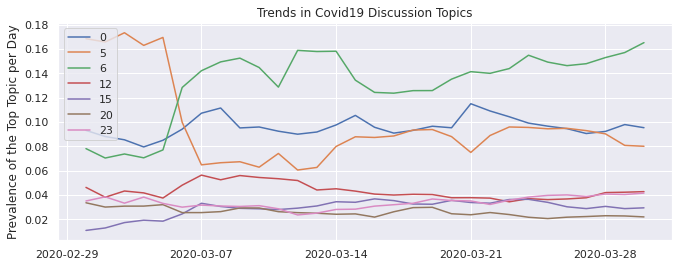

In [16]:
START = '2020-03-01'
END = '2020-03-31'
fig, ax = plt.subplots()
for topic_id in ['0', '5', '6', '12', '15', '20', '23']:
    ax.plot(max_counts.loc[START:END, int(topic_id)], label=topic_id)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.legend()
    ax.set_ylabel('Prevalence of the Top Topic per Day')
    ax.set_title('Trends in Covid19 Discussion Topics');

## 2.2 Average of Topic Weights per Day

In [12]:
df = dtm.merge(metadata, on="position_index", how="left")
df['Date'] = pd.to_datetime(df['created_time'])
df = df.set_index('Date')
del dtm, metadata

### Plot Average of Topic Weights per Day

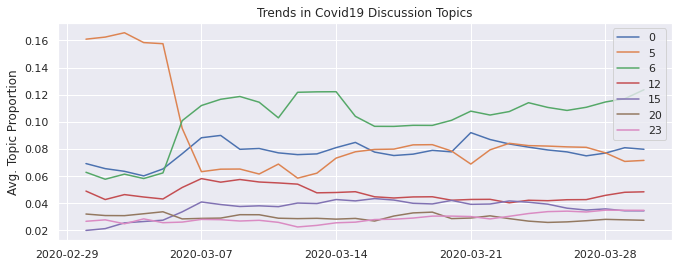

In [13]:
START = '2020-03-01'
END = '2020-03-31'
GRAN = "D"
fig, ax = plt.subplots()
# '5', '6'
for topic_id in ['0', '5', '6', '12', '15', '20', '23']:
    ax.plot(df.loc[START:END, int(topic_id)].resample(GRAN).mean(), label=topic_id)
    # ax.set_xlim((np.datetime64(START), np.datetime64(END)))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.legend()
    ax.set_ylabel('Avg. Topic Proportion')
    ax.set_title('Trends in Covid19 Discussion Topics');